In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F
from pyspark.sql.functions import (
    when, countDistinct, count, avg,
    split, explode, trim, lit, length,
    current_date, row_number, regexp_replace,
    to_date, coalesce, col, when,
    year, month, dayofmonth, array_contains, min, max, year
)
from pyspark.sql.functions import sum as spark_sum
from pyspark.sql.window import Window
import numpy as np

In [0]:
# to read the data set with previous tranformations
df = spark.read.parquet("/FileStore/tables/Imdb_Movie_Dataset-2.parquet")
display(df.limit(5))

id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,budget,imdb_id,original_language,original_title,overview,popularity,tagline,genres,production_companies,production_countries,spoken_languages,keywords
257391,Mahal,5.5,8,Released,1/1/1949,0,165,false,0,tt0041619,hi,महल,"A young lawyer is involved with a ghostly woman in his new house, where the builder and his fiancée died shortly after it was built.",1.735,null,"Romance, Horror, Drama",Bombay Talkies,India,Hindi,"reincarnation, ghost story"
593495,The Reliant,3.9,8,Released,10/24/2019,0,140,false,0,tt6105774,en,The Reliant,"Economic collapse causes widespread rioting and social unrest, leaving a lovesick 19-year-old girl struggling to care for her siblings in a stretch of woods bordered by lawless anarchy, wondering why a good God would let this happen.",1.978,Why do bad things happen to good people?,"Action, Family",Fervent House Media,United States of America,English,"based on novel or book, riot, lawlessness, god, anarchy, social unrest"
198526,The Magic Touch,6.9,8,Released,1/24/1992,0,100,false,0,tt0105386,cn,神算,"Hui Wai-kuk (Michael Hui) tells people's fortunes by feeling their bones. In reality though, he is a scam artist who gathers information on his clients in advance and uses it to milk them for money. When the wife of Commissioner David Ho (Philip Chan) of the Inland Revenue Department (IRD) comes to see him, he reveals that her husband is cheating on her. After facing the wrath of his wife, Ho decides to get revenge and sends junior assessor Yau Ho-kei (Leon Lai) to investigate Hui's income. During the investigation, Hui sustains a brain injury and slips into a coma. After he wakes up, he suddenly discovers that he has gained the real ability to see people's futures.",1.742,null,Comedy,"Hui's Film Production Co., Ltd., Topping Time Films Ltd.",Hong Kong,Cantonese,null
102508,Platillos volantes,5.5,8,Released,11/7/2003,0,99,false,0,tt0388341,es,Platillos volantes,"Based on real events, in 1972 Juan and José are two textile workers from Tarrasa, Catalonia (northeast to Spain) who meet during an UFOs' convention. Both share their passion about the paranormal, specially about UFOs. In these years where was very much UFOs' sightings, they feel captivated by the mystery and start to investigate the diverse theories about the intentions or purposes of the sightings. Their friendship and the obsession they have will turn in dementia and paranoia, hurting their relations with their respective friends and familiars and exposing their lives to an extreme decision due to the conclusion of their own investigations. Written by Chockys",2.031,null,"Drama, Science Fiction",Enrique Cerezo,Spain,Spanish,null
247477,Law and Disorder,6.2,8,Released,6/9/1958,0,76,false,0,tt0051847,en,Law and Disorder,"When Percy Brand, a habitual confidence trickster, keeps being sent down, he goes to great lengths to ensure that his son Colin, does not find out about his criminal past. But when Colin becomes an assistant to the Judge, who is about to try Percy for his latest escapade, Percy and his gang have to come up with a plan, to stop them meeting in court.",1.937,Michael Redgrave with an ingenious hand for disorder ... Robert Morley as the intrepid arm of the law ...,Comedy,"Paul Soskin Productions, British Lion Films",United Kingdom,English,lawyer


In [0]:
# how many rows do we have
total_rows = df.count()
print(f"Total rows in `df`: {total_rows}")

Total rows in `df`: 1048575


In [0]:
# To check the type of each feature
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- vote_average: double (nullable = true)
 |-- vote_count: integer (nullable = true)
 |-- status: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- revenue: long (nullable = true)
 |-- runtime: integer (nullable = true)
 |-- adult: boolean (nullable = true)
 |-- budget: integer (nullable = true)
 |-- imdb_id: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: double (nullable = true)
 |-- tagline: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- spoken_languages: string (nullable = true)
 |-- keywords: string (nullable = true)



%md
## Categorical Feature Analysis

%md
All numerical variables have been analyzed.

%md
### TITLE

In [0]:
# Safe copy of the original DataFrame
df_copy3 = df.select("*")

In [0]:
# Count null, empty, and "None"/"none" titles
null_count = df_copy3.filter(col("title").isNull()).count()
empty_count = df_copy3.filter((col("title") == "") | (col("title") == " ")).count()
none_count = df_copy3.filter((col("title") == "None") | (col("title") == "none")).count()

print(f"Null titles: {null_count}")
print(f"Empty titles: {empty_count}")
print(f"None titles: {none_count}")

Null titles: 13
Empty titles: 3
None titles: 0


In [0]:
# Title length distribution
title_len_df = df_copy3.withColumn("title_length", length(col("title")))
min_len = title_len_df.agg({"title_length": "min"}).collect()[0][0]
max_len = title_len_df.agg({"title_length": "max"}).collect()[0][0]
median_len = title_len_df.approxQuantile("title_length", [0.5], 0.01)[0]
print(f"Title length — min: {min_len}, median: {median_len:.0f}, max: {max_len}")

# Show extremes
print("Longest titles:")
display(
    title_len_df
    .orderBy(col("title_length").desc())
    .select("id", "title", "title_length")
    .limit(5)
)
print("Shortest non-empty titles:")
display(
    title_len_df
    .filter(col("title").isNotNull() & (col("title") != ""))
    .orderBy(col("title_length").asc())
    .select("id", "title", "title_length")
    .limit(5)
)


Title length — min: 1, median: 17, max: 324
Longest titles:


id,title,title_length
622274,"NHDTA-775 Climaxing Over and Over! Repeated Family Creampies! - My Big Sister Was A Cold Bitch When I Fucked Her With A Condom On, But When I Secretly Fucked Her Raw She Suddenly Turned Into A Screaming Banshee! She Started Cumming Over And Over Again! We Did So Many Family Creampies Together! The Big Sister Gal Edition 01",324
1047540,"Obedient Married Woman With A Shaved Pussy - 37-Year-Old Yuri Momose's Adult Video Debut - She's A Hottie Who Used To Be A Nude Model And Misses The Thrill Of Being Watched. This Nympho Wife Is So Horny She's Raring To Fuck Any Time, Any Place! Yuri Momose",256
838829,"Ravished! The Chains Of Betrayal! Private Girls' School Student! If You Don't Want My Creampie, Call Your Friends! She Calls Her Own Mother, Who In Turn Calls A Friend To Take Her Place! Made To Cum With Endless Pounding And Creampie Sex - 10 Loads In All!",256
999778,"An Amateur Couple Focus Group Investigation We Went On A Search For A Lovey Dovey Couple Anywhere On The Street And Asked Them To Take On An Extreme Mission! If This Couple Can Engage In Partner Swapping In Front Of Our Cameras, They'll Win 1 Million Yen!!",256
862328,A Video Record of Secretly Filmed Footage by the Manager of an Office Lady Dormitory I Was Staring at This Voluptuous Female Employee with Light Skin and Her Big Erotic Ass When She Invited Me to Her Room One Afternoon and We Fucked Like Crazy Aya Miyazaki,256


Shortest non-empty titles:


id,title,title_length
602732,1,1
301221,E,1
980113,2,1
1099640,!,1
349429,큐,1


%md
`title` column does not have any missing values and is stored with the correct data type. However, we noticed that some movies have titles consisting of only a single character. While this is unusual, it is not impossible in the context of cinema. Therefore, we will investigate this further to understand how many such cases exist in the dataset.

In [0]:
# Count the number of films with just one character as title
single_char_titles_count = df_copy3.filter(length(col("title")) == 1).count()

print(f"Number of movies with single-character titles: {single_char_titles_count}")

# display them
display(df_copy3.filter(length(col("title")) == 1).limit(5))

Number of movies with single-character titles: 572


id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,budget,imdb_id,original_language,original_title,overview,popularity,tagline,genres,production_companies,production_countries,spoken_languages,keywords
166634,G,5.571,7,Released,4/11/2011,0,14,false,0,tt1860234,es,G,A short by Diego Puertas.,1.053,null,"Crime, Comedy",null,null,null,null
523691,M,4.1,7,Released,10/4/2018,0,90,false,0,tt8774708,en,M,"M is a work of art that explores the relationship between sexuality and death. These two appear to be at opposite poles, but in fact they merge in all of us, disguising the fear of death or the desire to die, the world of Eros. In M the character of Marilyn Monroe should be seen as a symbol of this interpenetration. The actress´s death is as famous as her sexuality and thus sets a perfect example of how the ancient bond between sex and death is being forever mystified and exploited by the popular culture. M attempts to explore this phenomenon in a much more personal level.",0.6,null,Mystery,"Ihode Management, Cursum Perficio",Finland,English,null
381403,5,4.5,7,Released,1/28/2016,0,77,false,0,tt3370900,en,5,"In the city of New York lives FIVE (Carolina War), a woman always faithful to its rules. With skill and intelligence makes unconventional theft without violence. Greed will break one of its rules and end locked in a mysterious apartment. FIVE gradually you will realize that fell into a trap and right there starts a race against time where you need to test all your skills to escape before it's too late.",2.212,null,null,null,null,null,null
817381,С,9.643,7,Released,null,0,0,false,0,null,ru,С,null,1.2,null,null,Pchela Animation Studio,Russia,null,null
664188,A,5.357,7,Released,11/24/2017,0,15,false,0,tt6083120,xx,A,"A world like ours, limited by language.",0.6,null,"Comedy, Drama",null,Ecuador,No Language,null


%md
Although it may seem unusual for a film to have a single-character title, we have decided to keep these entries in our dataset. Despite their atypical titles, these films contain relevant information for most of our features and therefore remain valuable for our analysis."

%md
### STATUS

%md
Let's check for distinct values 

In [0]:
# Count distinct non-null statuses
distinct_status_count = df_copy3.filter(col("status").isNotNull()).select("status").distinct().count()
print(f"Number of distinct 'status' values (excluding nulls): {distinct_status_count}")

# Show frequency of each status
status_counts = df_copy3.groupBy("status").count().orderBy(col("count").desc())
print("Counts per status:")
display(status_counts)

Number of distinct 'status' values (excluding nulls): 6
Counts per status:


status,count
Released,1022770
In Production,10617
Post Production,8244
Planned,6337
Rumored,345
Canceled,262


In [0]:
# Calculate average and median revenue by status
status_revenue_stats = (
    df_copy3
    .groupBy("status")
    .agg(
        F.avg("revenue").alias("average_revenue"),
        F.expr("percentile_approx(revenue, 0.5)").alias("median_revenue")
    )
    .orderBy("status")
)

# Display the results
display(status_revenue_stats)

status,average_revenue,median_revenue
Canceled,0.7633587786259542,0
In Production,301551.0324950551,0
Planned,11.643206564620483,0
Post Production,371785.8715429403,0
Released,773469.472768071,0
Rumored,470.3942028985507,0


In [0]:
total_count = df_copy3.count()
non_released_count = df_copy3.filter(col("status") != "Released").count()
percentage = (non_released_count / total_count) * 100

print(f"Non-released movies: {non_released_count} ({percentage:.2f}%)")

Non-released movies: 25805 (2.46%)


In [0]:
# display them
display(df_copy3.filter(col("status") != "Released").limit(5))

id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,budget,imdb_id,original_language,original_title,overview,popularity,tagline,genres,production_companies,production_countries,spoken_languages,keywords
413749,Logan's Run,7.8,4,Planned,null,0,0,false,0,tt0402344,en,Logan's Run,A remake of the dystopian 1976 science fiction film Logan’s Run.,0.898,null,"Action, Adventure, Drama, Science Fiction, Thriller","Silver Pictures, Warner Bros. Pictures",United States of America,English,"based on novel or book, dystopia, remake"
496323,Mogul: The Gulshan Kumar Story,10.0,3,Planned,null,0,0,false,0,tt6665550,hi,Mogul: The Gulshan Kumar Story,"Biopic of Gulshan Kumar, the founder of the Indian music company, T-Series.",4.583,The emperor of music.,"Drama, Music",T-Series,India,Hindi,"biography, record label"
465660,Force 3,10.0,3,Planned,null,0,0,false,0,null,hi,Force 3,null,0.6,null,"Thriller, Action",null,India,Hindi,null
345933,Imagine Agents,10.0,3,Planned,null,0,0,false,0,null,en,Imagine Agents,Based off the Boom! comic.,0.6,null,null,null,null,null,null
528319,Firefighters,10.0,3,Planned,null,0,0,false,0,tt8515620,en,Firefighters,"The true story of a dozen female prisoners as they move from county jail to life in a Malibu fire camp. With only three weeks of training, the diverse crew must bind together not only to fight devastating blazes, but also their own personal demons and a system that seeks to keep them invisible. It is a task they signed up for, and get paid $2 an hour to risk their lives.",0.6,null,Drama,"LuckyChap Entertainment, Automatik Entertainment, Good Films Collective",United States of America,English,null


%md
These entries represent less than 1% of the dataset and contain incomplete or unreliable information for modeling. Since the goal is to analyze actual outcomes, we will retain only films with Released status.

In [0]:
# to remove these entries
df_copy3 = df_copy3.filter(col("status") == "Released")

%md
Since at this point all the movies in our dataset are already released,  which was our objective from the beginning,  this column becomes completely unnecessary as it now contains only a single unique value. Therefore, we will remove it from our DataFrame.

In [0]:
# to remove the column status
df_copy3 = df_copy3.drop("status")

# just to check
df_copy3.printSchema()

root
 |-- id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- vote_average: double (nullable = true)
 |-- vote_count: integer (nullable = true)
 |-- release_date: string (nullable = true)
 |-- revenue: long (nullable = true)
 |-- runtime: integer (nullable = true)
 |-- adult: boolean (nullable = true)
 |-- budget: integer (nullable = true)
 |-- imdb_id: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: double (nullable = true)
 |-- tagline: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- spoken_languages: string (nullable = true)
 |-- keywords: string (nullable = true)



%md
### ADULT

In [0]:
# Check distinct values in the "adult" column and count their occurrences
distinct_adult = df_copy3.groupBy("adult").count()

# Get the number of distinct values in the "adult" column
distinct_adult_count = distinct_adult.count()
print(f"Number of distinct values in 'adult': {distinct_adult_count}")

# Display the distinct values along with their counts
display(distinct_adult.limit(5))

Number of distinct values in 'adult': 2


adult,count
true,96665
false,926105


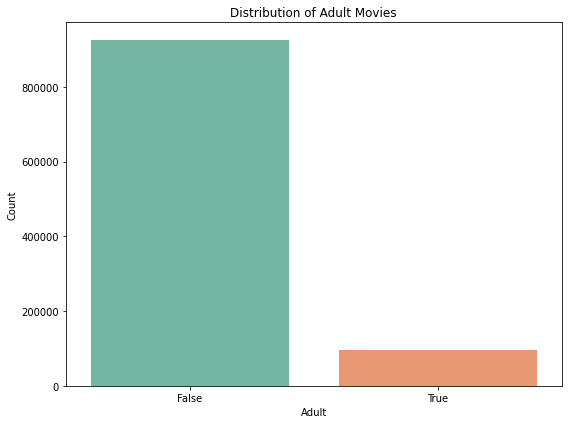

In [0]:
# Plot distribution of 'adult' values

# Count occurrences of each distinct value in 'adult' column
adult_distribution = df_copy3.groupBy("adult").count().toPandas()

# Plot the distribution
plt.figure(figsize=(8, 6))
sns.barplot(x='adult', y='count', data=adult_distribution, palette='Set2')
plt.title('Distribution of Adult Movies')
plt.xlabel('Adult')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

%md
Overwhelming majority of the movies is **not** for adults only

%md
### ORIGINAL_LANGUAGE

In [0]:
# Summary of null, empty-string, "None"/"none", and zero counts for original_language
for cname in ["original_language"]:
    nulls   = df_copy3.filter(col(cname).isNull()).count()
    empties = df_copy3.filter((col(cname) == "") |(col(cname) == " ")).count()
    nones   = df_copy3.filter(col(cname).isin("None", "none")).count()
    zeros   = df_copy3.filter(col(cname) == "0").count()

    print(
        f"{cname}: nulls={nulls}, "
        f"empty strings={empties}, "
        f"'None'/'none' strings={nones}, "
        f"zero values={zeros}"
    )

original_language: nulls=0, empty strings=0, 'None'/'none' strings=0, zero values=0


In [0]:
# Print number of unique "original_language"
unique_lang_count = df_copy3.select("original_language").distinct().count()
print(f"Number of unique original_language: {unique_lang_count}")

Number of unique original_language: 172


In [0]:
# Print unique "original_language" values and their counts
df_copy3.groupBy("original_language") \
  .count() \
  .orderBy(col("count").desc()) \
  .show(90, False) # number of rows to display, turn off truncation to see full column values

+-----------------+------+
|original_language|count |
+-----------------+------+
|en               |552878|
|fr               |60444 |
|es               |51292 |
|de               |49074 |
|ja               |45118 |
|zh               |35974 |
|pt               |29304 |
|it               |21766 |
|ru               |20866 |
|ko               |11677 |
|cs               |9506  |
|nl               |8111  |
|sv               |7718  |
|ar               |7443  |
|hi               |7121  |
|tr               |7111  |
|pl               |6584  |
|tl               |5880  |
|xx               |4934  |
|cn               |4833  |
|da               |4651  |
|ta               |4127  |
|el               |4125  |
|id               |3816  |
|ml               |3506  |
|hu               |3407  |
|fa               |3397  |
|th               |3099  |
|fi               |2878  |
|bn               |2713  |
|te               |2528  |
|no               |2447  |
|sk               |2406  |
|he               |2289  |
|

%md
The listed short forms of languages refer to:
- **tn**: Tswana
- **zh**: Chinese
- **ko**: Korean
- **hi**: Hindi

https://www.science.co.il/language/Codes.php

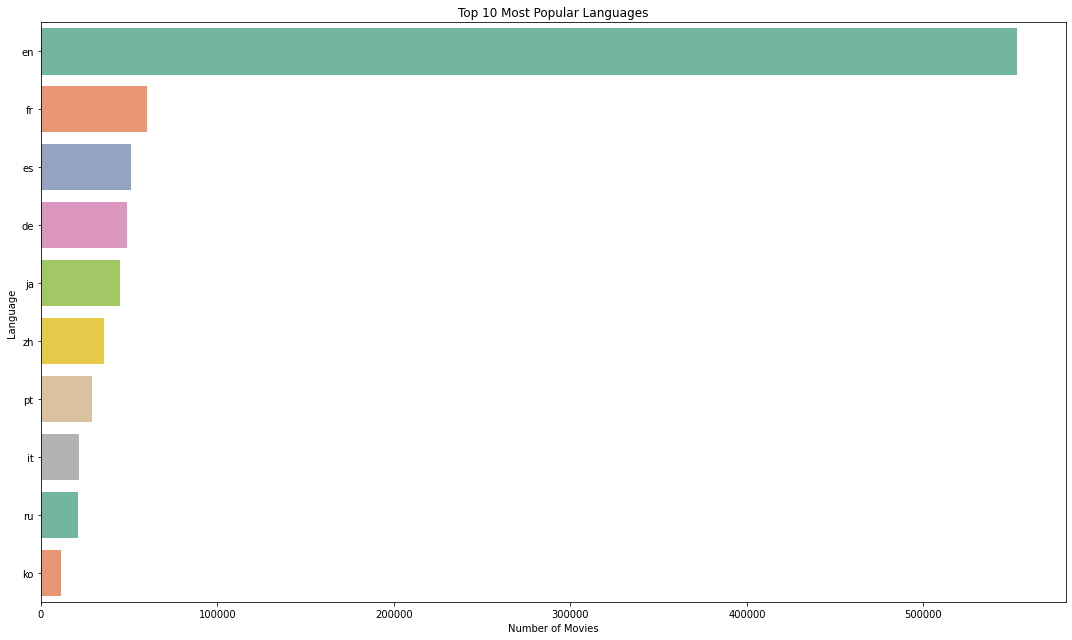

In [0]:
# Group by original_language and count occurrences
language_counts = df_copy3.groupBy("original_language").count().orderBy(col("count").desc())

# Show top 5 languages by count
top_languages = language_counts.limit(10).toPandas()

# Plot top 5 languages
plt.figure(figsize=(15, 9))
sns.barplot(x="count", y="original_language", data=top_languages, palette="Set2")
plt.title('Top 10 Most Popular Languages')
plt.xlabel('Number of Movies')
plt.ylabel('Language')
plt.tight_layout()
plt.show()

In [0]:
# Count the number of English-language movies
count_en = df_copy3.filter(col("original_language") == "en").count()

# Count the number of Spanish-language movies
count_es = df_copy3.filter(col("original_language") == "es").count()

# Calculate the percentage of Spanish movies compared to English
percentage_es_vs_en = (count_es / count_en) * 100

# Print the result
print(f"Spanish-language movies represent {percentage_es_vs_en:.2f}% of English-language movies.")

Spanish-language movies represent 9.28% of English-language movies.


%md
Great majority of the movies was filmed in english as the original language. To reduce cardinality we will create a new column `en_bool`, where 1 will denote the original language was english and 0 for other original language

In [0]:
# Create a boolean (0/1) column 'en_bool' for whether original_language == 'en'
df_copy3 = df_copy3.withColumn(
    "en_bool",
    when(col("original_language") == "en", lit(1)).otherwise(lit(0))
)

# Verify
df_copy3.select("original_language", "en_bool").show(10, False)

+-----------------+-------+
|original_language|en_bool|
+-----------------+-------+
|hi               |0      |
|en               |1      |
|cn               |0      |
|es               |0      |
|en               |1      |
|cn               |0      |
|en               |1      |
|fr               |0      |
|ru               |0      |
|pt               |0      |
+-----------------+-------+
only showing top 10 rows



In [0]:
# Compute distribution of values in "en_bool"
dist_df = df_copy3.groupBy("en_bool").count().orderBy("en_bool")

# Show the distribution counts
dist_df.show()

+-------+------+
|en_bool| count|
+-------+------+
|      0|469892|
|      1|552878|
+-------+------+



%md
We now have a variable that shows good balance and strong relevance for our predictive model.

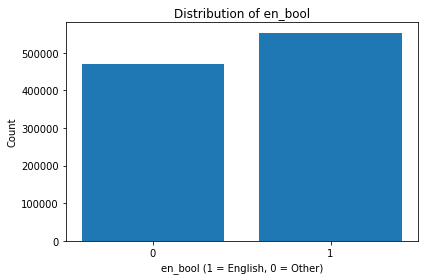

In [0]:
# Convert to Pandas for plotting
dist_pd = dist_df.toPandas()

# Plot the distribution
plt.figure(figsize=(6, 4))
plt.bar(dist_pd["en_bool"].astype(str), dist_pd["count"])
plt.xlabel("en_bool (1 = English, 0 = Other)")
plt.ylabel("Count")
plt.title("Distribution of en_bool")
plt.tight_layout()
plt.show()

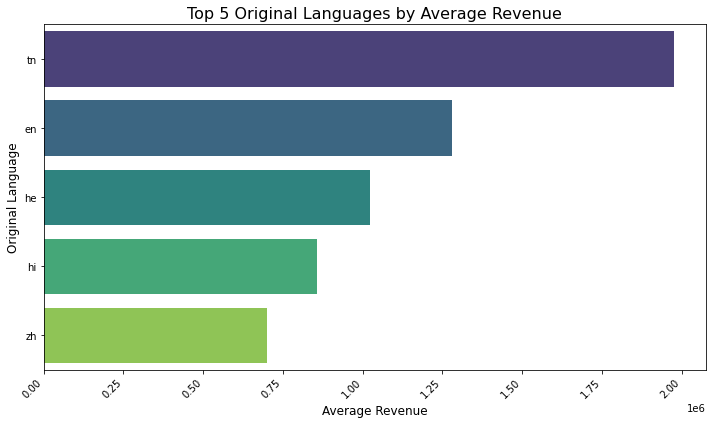

In [0]:
# Group by original_language and calculate the average revenue
language_revenue_avg = df_copy3.groupBy("original_language") \
    .agg(F.avg("revenue").alias("average_revenue"))

# Sort the languages by average revenue in descending order
language_revenue_avg = language_revenue_avg.orderBy(col("average_revenue").desc()).limit(5)

# Convert to Pandas for visualization
language_revenue_avg_pd = language_revenue_avg.toPandas()

# 4) Create a pretty bar plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x="average_revenue", 
    y="original_language", 
    data=language_revenue_avg_pd, 
    palette="viridis"  # Color palette
)

# Add titles and labels for clarity
plt.title('Top 5 Original Languages by Average Revenue', fontsize=16)
plt.xlabel('Average Revenue', fontsize=12)
plt.ylabel('Original Language', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

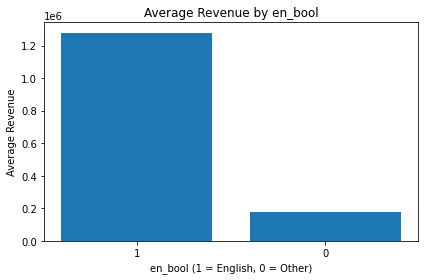

In [0]:
# Group by en_bool and compute average revenue
avg_rev_en = df_copy3.groupBy("en_bool").agg(F.avg("revenue").alias("average_revenue"))

# Convert to Pandas
avg_rev_en_pd = avg_rev_en.toPandas()

# Simple plot
plt.bar(avg_rev_en_pd["en_bool"].astype(str), avg_rev_en_pd["average_revenue"])
plt.xlabel("en_bool (1 = English, 0 = Other)")
plt.ylabel("Average Revenue")
plt.title("Average Revenue by en_bool")
plt.tight_layout()
plt.show()

%md
As expected, the majority of the movies are in English, which also explains the higher overall revenue associated with this language.

%md
### ORIGINAL_TITLE

In [0]:
# Count the total number of rows
total_rows = df_copy3.count()

# Count the number of rows where the original_title is different from title
different_titles_count = df_copy3.filter(col("original_title") != col("title")).count()

# Calculate the percentage of rows where original_title is different from title
percentage_different_titles = (different_titles_count / total_rows) * 100

print(f"Total rows: {total_rows}")
print(f"Number of movies with different 'original_title' than 'title': {different_titles_count}")
print(f"Percentage of movies with different titles: {percentage_different_titles:.2f}%")

Total rows: 1022770
Number of movies with different 'original_title' than 'title': 203504
Percentage of movies with different titles: 19.90%


In [0]:
# Summary of null, empty-string, "None"/"none", and zero counts for 'original_title' column

nulls   = df_copy3.filter(col("original_title").isNull()).count()
empties = df_copy3.filter((col("original_title") == "") | (col("original_title") == " ")).count()
nones   = df_copy3.filter(col("original_title").isin("None", "none")).count()
zeros   = df_copy3.filter(col("original_title") == "0").count()

print(f"original_title: nulls={nulls}, empty strings={empties}, 'None'/'none' strings={nones}, zero values={zeros}")

original_title: nulls=11, empty strings=0, 'None'/'none' strings=0, zero values=8


In [0]:
# Add a column with the length of each original_title
df_length = df_copy3.withColumn("original_title_length", length(col("original_title")))

# Compute min, max, avg, and median of original_title_length
stats = (
    df_length
    .agg(
        F.min("original_title_length").alias("min_length"),
        F.max("original_title_length").alias("max_length"),
        F.avg("original_title_length").alias("avg_length"),
        F.expr("percentile_approx(original_title_length, 0.5)").alias("median_length")
    )
    .collect()[0]
)

min_length    = stats["min_length"]
max_length    = stats["max_length"]
avg_length    = stats["avg_length"]
median_length = stats["median_length"]

print(f"Shortest original_title length: {min_length}")
print(f"Longest original_title length : {max_length}")
print(f"Average original_title length : {avg_length:.1f}")
print(f"Median original_title length  : {median_length}")

# Show examples of the shortest and longest original_titles
print("Examples of shortest original_titles:")
display(
    df_length
      .filter(col("original_title_length") == min_length)
      .select("id", "title", "original_title", "original_title_length")
      .limit(5)
)

print("Examples of longest original_titles:")
display(
    df_length
      .filter(col("original_title_length") == max_length)
      .select("id", "title", "original_title", "original_title_length")
      .limit(5)
)


Shortest original_title length: 1
Longest original_title length : 250
Average original_title length : 18.9
Median original_title length  : 16
Examples of shortest original_titles:


id,title,original_title,original_title_length
199203,Rice,米,1
257187,The Wolves,狼,1
166634,G,G,1
523691,M,M,1
381403,5,5,1


Examples of longest original_titles:


id,title,original_title,original_title_length
1410443,I Ordered A Big Tits Delivery Health Call Girl And I Was Surprised To See That Was My Beautiful Teacher Who Always Scolded Me!!,"Kyonyû deriheru o yondara yattekita no wa ore o itsumo shikaritsukete ita bijin kyôshi J!! Kanojo no sei de taigaku ni nari, mote nai kin nai shigoto nai jinsei de fûzoku ni mo tamani shika hairenai tamari ni tamatta ore no seiyoku o butsukete yaru!!",250
1021513,"Há Quarenta Anos Era Lançado o Último Filme de Rainer Werner Fassbinder, Querelle de Brest, e Há Quarenta Anos Rainer Werner Fassbinder Partia Dessa Para Melhor, No Dia Dez de Junho de Mil Novecentos e Oitenta e Dois (dez dias após o seu aniversário)","Há Quarenta Anos Era Lançado o Último Filme de Rainer Werner Fassbinder, Querelle de Brest, e Há Quarenta Anos Rainer Werner Fassbinder Partia Dessa Para Melhor, No Dia Dez de Junho de Mil Novecentos e Oitenta e Dois (dez dias após o seu aniversário)",250
1281546,"DVMM-042: General Male/Female Monitoring Av Behind the Magic Mirror Is a Newly Remarried Mother! New Daddy Is a Black Man! a Schoolgirl's Daughter and Her New Dad Try Their Hand at Continuous Ejaculation Sex for 100,000 Yen a Shot in a Closed Room Al","DVMM-042: General Male/Female Monitoring Av Behind the Magic Mirror Is a Newly Remarried Mother! New Daddy Is a Black Man! a Schoolgirl's Daughter and Her New Dad Try Their Hand at Continuous Ejaculation Sex for 100,000 Yen a Shot in a Closed Room Al",250


%md
This category has too much diversity and will not add meaningful value to our model or to the main objective of this project. We will remove it.

In [0]:
df_copy3 = df_copy3.drop("original_title")

%md
### OVERVIEW

In [0]:
# Summary of null, empty-string, "None"/"none", and zero counts for 'overview' column
total = df_copy3.count()

nulls   = df_copy3.filter(col("overview").isNull()).count()
empties = df_copy3.filter((col("overview") == "") | (col("overview") == " ")).count()
nones   = df_copy3.filter(col("overview").isin("None", "none")).count()
zeros   = df_copy3.filter(col("overview") == "0").count()

print(f"overview: total={total}, nulls={nulls}, empty strings={empties}, 'None'/'none' strings={nones}, zero values={zeros}")

overview: total=1022770, nulls=209885, empty strings=966, 'None'/'none' strings=0, zero values=1


In [0]:
# Set those empty or whitespace-only overviews to null
df_copy3 = df_copy3.withColumn(
    "overview",
    when(trim(col("overview")) == "", None).otherwise(col("overview"))
)

# Then check again how many empty strings there are
empties = df_copy3.filter((col("overview") == "") |(col("overview") == " ")).count()
print(f"Number of empty strings left: {empties}")

Number of empty strings left: 0


In [0]:
# Add a column with the length of each overview
df_length = df_copy3.withColumn("overview_length", length(col("overview")))

# Compute min, max, avg, and median of overview_length
stats = (
    df_length
    .agg(
        F.min("overview_length").alias("min_length"),
        F.max("overview_length").alias("max_length"),
        F.avg("overview_length").alias("avg_length"),
        F.expr("percentile_approx(overview_length, 0.5)").alias("median_length")
    )
    .collect()[0]
)

min_length    = stats["min_length"]
max_length    = stats["max_length"]
avg_length    = stats["avg_length"]
median_length = stats["median_length"]

print(f"Shortest overview length: {min_length}")
print(f"Longest overview length : {max_length}")
print(f"Average overview length : {avg_length:.1f}")
print(f"Median overview length  : {median_length}")

# Show examples of the shortest and longest overviews
print("Examples of shortest overviews:")
display(
    df_length
      .filter(col("overview_length") == min_length)
      .select("id", "title", "overview", "overview_length")
      .limit(5)
)

print("Examples of longest overviews:")
display(
    df_length
      .filter(col("overview_length") == max_length)
      .select("id", "title", "overview", "overview_length")
      .limit(5)
)


Shortest overview length: 1
Longest overview length : 1000
Average overview length : 271.6
Median overview length  : 214
Examples of shortest overviews:


id,title,overview,overview_length
1117655,f,f,1
64798,Garrison,,1
707030,Untitled Video,ñ,1
1098391,t,t,1
1389822,P,P,1


Examples of longest overviews:


id,title,overview,overview_length
267048,The Pyramid,"The film is set in the middle of winter in Ystad and the main character is the middle-aged policeman Kurt Wallander, who this time investigating a drug tangle. It starts with his own goddaughter Eva found dead after taking an overdose. It turns out that heroin is unusually strong and Kurt are now beginning their search for those behind the drugs. But he has a big problem. His boss will not let him look for the person who he suspects has sold the new heroin , but she wants them to look for another drug dealer named Yngve Holm. But Kurt defy the boss's orders and go again and again to Malmo to try to unravel the case. Eventually he gets a hold of the person he suspected. He'll take some photos of him and shows them for their guddotters friend Emma who were drug dealers. She takes Kurt to a friend who claims to have seen the man. The man in the photo is called Heinrich Pasila. Wallander thinks one recognizes Pasila from an earlier murder of guddotterns mother, where the offender is found.",1000
249546,"Meu Compadre, Zé Ketti","Short musical film paying a tribute to samba composer Zé Ketti, one of the greatest popular artists of Brazilian music. In a jam session, in the late composer's house in Inhaúma, a neighborhood of Rio de Janeiro, a group of friends get together to play his music while a ""feijoada"" (typical Brazilian food with black beans)is being cooked in the kitchen. The samba-players, first-rate samba stars themselves, remember Ketti's great hits in a homage to the man who was best known as ""a voz do morro"" (""the hill's voice"" - but hill as a metaphor for a place where poor people build their shacks in slums, in opposition to city, where middle-class people live in Rio). Among the guests, names of the traditional ""samba-school"" Portela and ex-partners. Also, the presence of a black hat on an empty chair, represents the composer himself, who died in 1999, after a life of many accomplishments in music, and appearance in three of Dos Santos's films: ""Rio, 40 Graus"", ""Rio Zona Norte"" and ""Boca de Ouro"".",1000
242289,Hollow City,"A group of children, fleeing the war, is taken to Luanda accompanied by a nun. When they reach the aeroplane, 12-year-old N'Dala decides to leave the group and to reconnoitre the city. The nun then starts her unceasing quest for the missing boy. N'Dala, only carrying a textile bag and a doll made of wire, walks through the busy streets filled with people and traffic. Later he finds the tranquility of the island off the coast, where he meets the old fisherman Antonio, with whom he becomes friends. Not much later, he meets the lively, whimsical Zé, who is a little older than he is. N'Dala starts to experience the city and its inhabitants as increasingly forbidding and he would most like to return to the countryside from whence he came. Then he meets Joka, a fringe figure who persuades him to help with a robbery in exchange for money. With this film, Maria Joao Ganga wanted to provide a realistic sketch of the bitter political situation in Angola. One of her most important motivations ...",1000
244141,"Learn from Experience, Part One","Part 1 of a 2-part romance based on a story by noted author Kikuchi Kan. The central character here is Toyomi (played by Takako IRIE, star of Mizoguchi’s ""Water Magician), a rich young woman in love with Shintaro (Minoru TAKADA), a rich young man. Unfortunately, Shintaro’s father is in the process of arranging a marriage for him with Yurie (Chieko TAKEHISA), the scion of an even wealthier family. In order to avoid this, the two young lovers flee to Tokyo to live together. When Shintaro comes back to proclaim his intent to marry Toyomi, his father browbeats him into attending the long-arranged marriage meeting with Yurie. While Shintaro is back home, Toyomi goes on a vacation trip with her closest chum, Michiko (Yumeko AIZOME). At a class reunion, Toyomi is to distressed (at not having heard from Shintaro

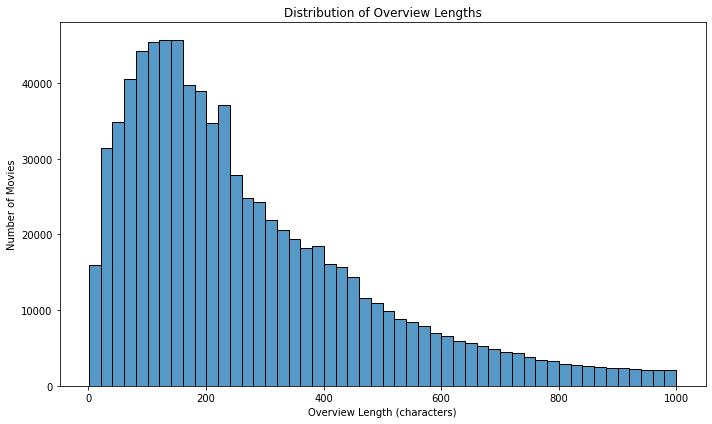

In [0]:
# Plot the distribution of overview lengths
overview_lengths_pd = df_length.select("overview_length").toPandas()

plt.figure(figsize=(10, 6))
sns.histplot(overview_lengths_pd["overview_length"], bins=50, kde=False)
plt.title("Distribution of Overview Lengths")
plt.xlabel("Overview Length (characters)")
plt.ylabel("Number of Movies")
plt.tight_layout()
plt.show()

%md
Distribution of overview leghts is right skewed. It indicates that most overviews have around 150 words. Only some have the maximum number of 998 characters.

In [0]:
df_copy3 = df_copy3.drop("overview_length")

%md
### TAGLINE

%md
The column `tagline` has the correct data type - string. Let's investigate this feature:

In [0]:
# Summary for 'tagline'
total = df_copy3.count()

nulls   = df_copy3.filter(col("tagline").isNull()).count()
empties = df_copy3.filter((col("tagline") == "") | (col("tagline") == " ")).count()
nones   = df_copy3.filter(col("tagline").isin("None", "none")).count()
zeros   = df_copy3.filter(col("tagline") == "0").count()

print(f"tagline: total={total}, nulls={nulls}, empty strings={empties}, 'None'/'none' strings={nones}, zero values={zeros}")

tagline: total=1022770, nulls=873893, empty strings=0, 'None'/'none' strings=2, zero values=2


In [0]:
# Replace "None"/"none" in `tagline` with null

# Count before replacement
none_count = df.filter(col("tagline").isin("None", "none")).count()
print(f"Taglines with 'None' or 'none' before cleanup: {none_count}")

# Perform replacement
df = df.withColumn(
    "tagline",
    when(col("tagline").isin("None", "none"), None).otherwise(col("tagline"))
)

# Verify post-replacement
post_none_count = df.filter(col("tagline").isNull()).count()
print(f"Taglines null after cleanup: {post_none_count}")

Taglines with 'None' or 'none' before cleanup: 2
Taglines null after cleanup: 895849


In [0]:
# Compute min, max, average, and median lengths of `tagline`
from pyspark.sql.functions import length, avg, expr, min as spark_min, max as spark_max

df_length = df_copy3.withColumn("tagline_length", length(col("tagline")))

stats = df_length.agg(
    spark_min("tagline_length").alias("min_length"),
    spark_max("tagline_length").alias("max_length"),
    avg("tagline_length").alias("avg_length"),
    expr("percentile_approx(tagline_length, 0.5)").alias("median_length")
).collect()[0]

print(f"Shortest tagline: {stats['min_length']}")
print(f"Longest  tagline: {stats['max_length']}")
print(f"Average  tagline: {stats['avg_length']:.1f}")
print(f"Median   tagline: {stats['median_length']}")

Shortest tagline: 1
Longest  tagline: 256
Average  tagline: 45.0
Median   tagline: 36


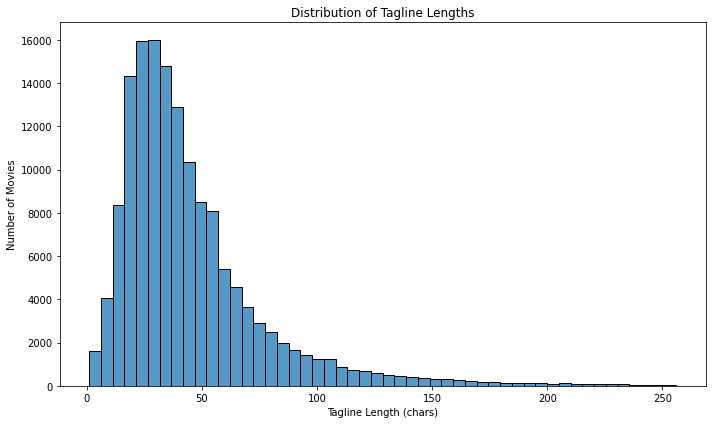

In [0]:
# Plot distribution of tagline lengths
# Convert to Pandas
lengths_pd = df_length.select("tagline_length").toPandas()["tagline_length"].dropna()

plt.figure(figsize=(10, 6))
sns.histplot(lengths_pd, bins=50, kde=False)
plt.title("Distribution of Tagline Lengths")
plt.xlabel("Tagline Length (chars)")
plt.ylabel("Number of Movies")
plt.tight_layout()
plt.show()

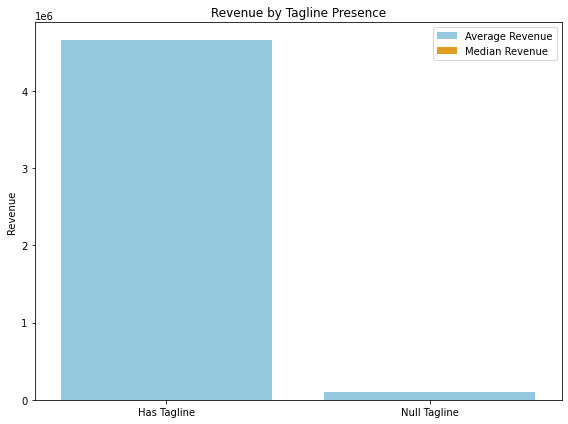

In [0]:
# Compare average revenue: tagline NULL vs non-NULL
# Compute stats
rev_stats = (
    df.groupBy(col("tagline").isNull().alias("tagline_null"))
      .agg(
          F.avg("revenue").alias("avg_revenue"),
          F.expr("percentile_approx(revenue, 0.5)").alias("median_revenue")
      )
      .orderBy("tagline_null")
      .toPandas()
)

# Map boolean to labels
rev_stats["tagline_null"] = rev_stats["tagline_null"].map({True: "Null Tagline", False: "Has Tagline"})

plt.figure(figsize=(8, 6))
sns.barplot(x="tagline_null", y="avg_revenue", data=rev_stats, color="skyblue", label="Average Revenue", ci=None)
sns.barplot(x="tagline_null", y="median_revenue", data=rev_stats, color="orange", label="Median Revenue", ci=None)
plt.title("Revenue by Tagline Presence")
plt.xlabel("")
plt.ylabel("Revenue")
plt.legend()
plt.tight_layout()
plt.show()

%md
To reduce complexity of this variable we will create a boolean feature "tagline_bool", for which value 1 will denote that the tagline was present and 0 for null taglines

In [0]:
# Create boolean column from "tagline" (0 if null, 1 if not)
df_copy3 = df_copy3.withColumn(
    "tagline_bool",
    when(col("tagline").isNull(), lit(0)).otherwise(lit(1))
)

+------------+------+
|tagline_bool| count|
+------------+------+
|           0|873893|
|           1|148877|
+------------+------+



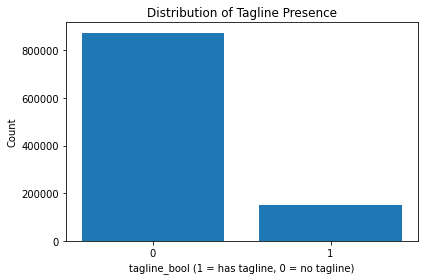

In [0]:
# Show counts of tagline_bool values
df_copy3.groupBy("tagline_bool") \
  .count() \
  .orderBy("tagline_bool") \
  .show()

#  Convert to Pandas for plotting
dist_pd = (
    df_copy3.groupBy("tagline_bool")
      .count()
      .orderBy("tagline_bool")
      .toPandas()
)

# Plot the distribution
plt.figure(figsize=(6, 4))
plt.bar(dist_pd["tagline_bool"].astype(str), dist_pd["count"])
plt.xlabel("tagline_bool (1 = has tagline, 0 = no tagline)")
plt.ylabel("Count")
plt.title("Distribution of Tagline Presence")
plt.tight_layout()
plt.show()

%md
Now that the `tagline` feature has been converted to a boolean, it becomes useful for our predictive model

%md
### GENRES

In [0]:
# Summary for 'genres'
total = df_copy3.count()

nulls   = df_copy3.filter(col("genres").isNull()).count()
empties = df_copy3.filter((col("genres") == "") | (col("genres") == " ")).count()
nones   = df_copy3.filter(col("genres").isin("None", "none")).count()
zeros   = df_copy3.filter(col("genres") == "0").count()

print(f"genres: total={total}, nulls={nulls}, empty strings={empties}, 'None'/'none' strings={nones}, zero values={zeros}")

genres: total=1022770, nulls=407875, empty strings=0, 'None'/'none' strings=0, zero values=0


In [0]:
df_copy3.select("genres").show(50, truncate=False)

+---------------------------------+
|genres                           |
+---------------------------------+
|Romance, Horror, Drama           |
|Action, Family                   |
|Comedy                           |
|Drama, Science Fiction           |
|Comedy                           |
|Action, Comedy                   |
|Documentary                      |
|Thriller                         |
|Romance, Drama                   |
|Drama                            |
|Drama, Comedy, TV Movie          |
|null                             |
|Drama, History                   |
|Science Fiction, Fantasy, Action |
|Animation, Music                 |
|Family, Fantasy, Adventure       |
|Drama                            |
|Animation                        |
|War, Drama                       |
|Drama                            |
|Romance, Comedy                  |
|Documentary                      |
|TV Movie, Comedy, Romance        |
|Drama, Romance                   |
|Drama                      

In [0]:
# Count occurrences of each distinct genre
# Split the comma-separated string into an array, trimming whitespace
df_copy3 = df_copy3.withColumn(
    "genres_array",
    split(col("genres"), "\\s*,\\s*")
)

# Explode the array so each genre gets its own row
genres_exploded = df_copy3.select(
    explode(col("genres_array")).alias("genre")
)

# Group by the individual genre values and count
genres_exploded.groupBy("genre") \
    .count() \
    .orderBy(col("count").desc()) \
    .show(100, False)  # adjust the number 100 if you want more or fewer rows

# Count the number of distinct genres
distinct_genre_count = genres_exploded.select("genre").distinct().count()
print(f"Number of distinct genres: {distinct_genre_count}")

+---------------+------+
|genre          |count |
+---------------+------+
|Drama          |205389|
|Documentary    |145198|
|Comedy         |128113|
|Animation      |51413 |
|Romance        |48892 |
|Horror         |48027 |
|Music          |44443 |
|Thriller       |42191 |
|Action         |40690 |
|Crime          |30950 |
|Family         |25587 |
|TV Movie       |22220 |
|Adventure      |21612 |
|Fantasy        |20628 |
|Science Fiction|19296 |
|Mystery        |18258 |
|History        |14941 |
|War            |9652  |
|Western        |8209  |
+---------------+------+

Number of distinct genres: 19


In [0]:
# Handle "genres" for boolean columns
# Explode into individual genres and plot top 10 by total revenue
df_copy3 = df_copy3.withColumn(
    "genres_array",
    split(regexp_replace(col("genres"), "\\s*,\\s*", ","), ",")
)

genre_rev_df = (
    df_copy3.select(explode(col("genres_array")).alias("genre"), col("revenue"))
      .groupBy("genre")
      .agg(spark_sum("revenue").alias("total_revenue"))
      .orderBy(col("total_revenue").desc())
)

genre_rev_df.show(10)

+---------------+-------------+
|          genre|total_revenue|
+---------------+-------------+
|         Action| 306272168161|
|      Adventure| 296746630376|
|         Comedy| 255241447160|
|          Drama| 236182347431|
|       Thriller| 161918297727|
|        Fantasy| 148418389386|
|Science Fiction| 147479955871|
|         Family| 137106369461|
|        Romance| 102910967941|
|      Animation|  98379889880|
+---------------+-------------+
only showing top 10 rows



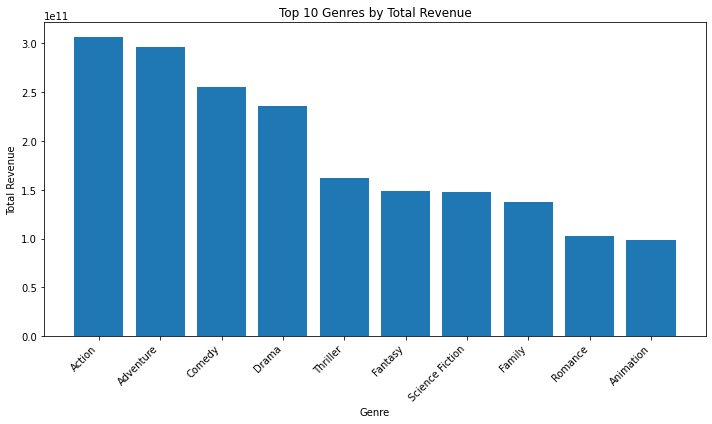

In [0]:
top10_genres = genre_rev_df.limit(10).toPandas()
plt.figure(figsize=(10,6))
plt.bar(top10_genres["genre"], top10_genres["total_revenue"])
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 Genres by Total Revenue")
plt.xlabel("Genre")
plt.ylabel("Total Revenue")
plt.tight_layout()
plt.show()

%md
Here we can clearly observe that the genres contributing to higher movie revenue are Action, Adventure, Comedy, and Drama, standing out significantly from the rest.

%md
To simplify this variable and make it more usable, we will transform it into six possible boolean combinations based on the five most common genres. If none of these genres are present (i.e., all five are set to 0), the movie will be classified as belonging to one of the remaining, less frequent genres.

In [0]:
# Create boolean columns for top 5 most profitable genres
top5_genres = [row["genre"] for row in genre_rev_df.limit(5).collect()]
for g in top5_genres:
    col_name = g.lower().replace(" ", "_")
    df_copy3 = df_copy3.withColumn(
        col_name,
        when(array_contains(col("genres_array"), g), lit(1)).otherwise(lit(0))
    )

Boolean columns for top 5 genres: ['action', 'adventure', 'comedy', 'drama', 'thriller']
+------+---------+------+-----+--------+
|action|adventure|comedy|drama|thriller|
+------+---------+------+-----+--------+
|0     |0        |0     |1    |0       |
|1     |0        |0     |0    |0       |
|0     |0        |1     |0    |0       |
|0     |0        |0     |1    |0       |
|0     |0        |1     |0    |0       |
|1     |0        |1     |0    |0       |
|0     |0        |0     |0    |0       |
|0     |0        |0     |0    |1       |
|0     |0        |0     |1    |0       |
|0     |0        |0     |1    |0       |
+------+---------+------+-----+--------+
only showing top 10 rows



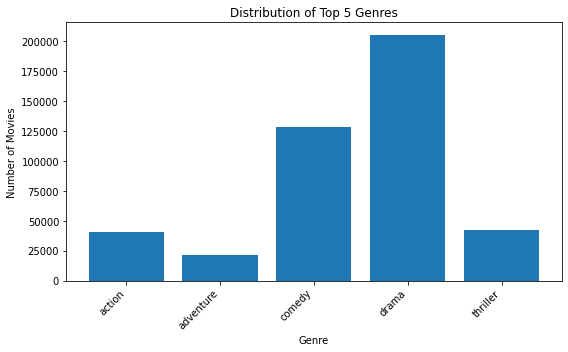

In [0]:
# recover the list of boolean columns
bool_cols   = [g.lower().replace(" ", "_") for g in top5_genres]

# View the first 10 rows of those boolean columns
print("Boolean columns for top 5 genres:", bool_cols)
df_copy3.select(bool_cols).show(10, False)

# Count how many movies have each genre (sum of the 1s)
counts_df = df_copy3.select([spark_sum(col(c)).alias(c) for c in bool_cols]) \
              .toPandas() \
              .melt(var_name="genre", value_name="count")

# Plot the distribution
plt.figure(figsize=(8, 5))
plt.bar(counts_df["genre"], counts_df["count"])
plt.xlabel("Genre")
plt.ylabel("Number of Movies")
plt.title("Distribution of Top 5 Genres")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

%md
From this chart, and based on what we already knew, we can see that the Adventure genre, although it is the least represented among the five most popular genres in our dataset, ends up having the second highest average revenue. This highlights its strong impact on box office performance.

%md
### PRODUCTION_COMPANIES

In [0]:
# Summary for 'production_companies'
total = df_copy3.count()

nulls   = df_copy3.filter(col("production_companies").isNull()).count()
empties = df_copy3.filter((col("production_companies") == "") | (col("production_companies") == " ")).count()
nones   = df_copy3.filter(col("production_companies").isin("None", "none")).count()
zeros   = df_copy3.filter(col("production_companies") == "0").count()

print(f"production_companies: total={total}, nulls={nulls}, empty strings={empties}, 'None'/'none' strings={nones}, zero values={zeros}")

production_companies: total=1022770, nulls=556743, empty strings=0, 'None'/'none' strings=0, zero values=2


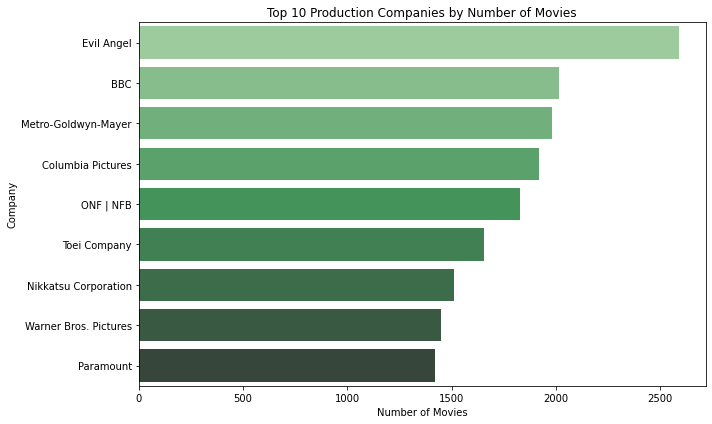

In [0]:
# Top 10 production_companies by number of movies
company_counts = (
    df_copy3
    .groupBy("production_companies")
    .count()
    .orderBy(col("count").desc())
    .limit(10)
    .toPandas()
)

plt.figure(figsize=(10,6))
sns.barplot(x="count", y="production_companies", data=company_counts, palette="Greens_d")
plt.title("Top 10 Production Companies by Number of Movies")
plt.xlabel("Number of Movies")
plt.ylabel("Company")
plt.tight_layout()
plt.show()


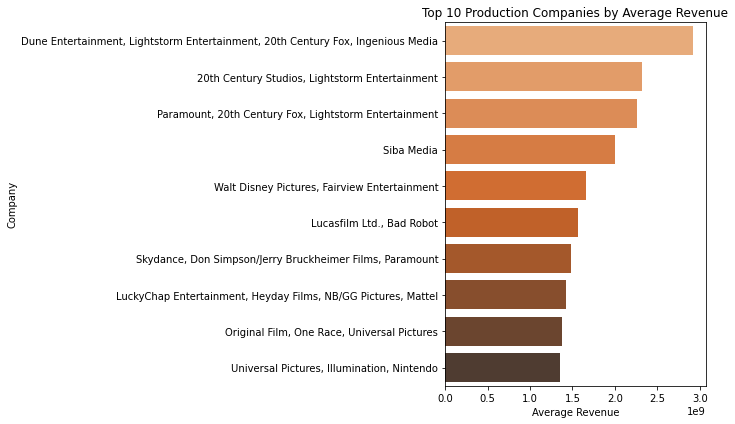

In [0]:
# Top 10 production_companies by average revenue

company_revenue = (
    df_copy3
    .groupBy("production_companies")
    .agg(avg("revenue").alias("avg_revenue"))
    .orderBy(col("avg_revenue").desc())
    .limit(10)
    .toPandas()
)

plt.figure(figsize=(10,6))
sns.barplot(x="avg_revenue", y="production_companies", data=company_revenue, palette="Oranges_d")
plt.title("Top 10 Production Companies by Average Revenue")
plt.xlabel("Average Revenue")
plt.ylabel("Company")
plt.tight_layout()
plt.show()


%md
From these two charts, it is easy to see that the number of films produced does not necessarily reflect quality or success. For example, Metro-Goldwyn-Mayer is the company with the highest number of productions, yet when looking at the top 10 production companies by revenue, it ranks only 10th. This highlights the discrepancy between quantity and profitability.

%md
There are many high-cardinality cells in `production_companies`. Therefore, we will create boolean columns, for the top 6 most profitable ones

In [0]:
# Split & explode high‐cardinality “production_companies”
df_copy3 = df_copy3.withColumn(
    "prod_companies_array",
    split(
        regexp_replace(col("production_companies"), r"\s*,\s*", ","),  # normalize commas
        ","
    )
)
prod_exploded = df_copy3.select(
    explode(col("prod_companies_array")).alias("company"),
    col("revenue")
)

In [0]:
# Count occurrences & distinct count
prod_counts = (
    prod_exploded
      .groupBy("company")
      .count()
      .orderBy(col("count").desc())
)
prod_counts.show(10, False)  # show top 10 by frequency
print(f"Number of distinct production companies: {prod_counts.count()}")

+---------------------+-----+
|company              |count|
+---------------------+-----+
|Warner Bros. Pictures|3126 |
|BBC                  |2929 |
|Columbia Pictures    |2863 |
|Metro-Goldwyn-Mayer  |2783 |
|Evil Angel           |2640 |
|Paramount            |2443 |
|ARTE                 |2438 |
|Universal Pictures   |2401 |
|ZDF                  |2229 |
|ONF | NFB            |2177 |
+---------------------+-----+
only showing top 10 rows

Number of distinct production companies: 152589


+---------------------+-------------+
|company              |total_revenue|
+---------------------+-------------+
|Warner Bros. Pictures|81590953294  |
|Universal Pictures   |77772675921  |
|20th Century Fox     |64047931866  |
|Paramount            |63604411894  |
|Columbia Pictures    |59954170937  |
|Walt Disney Pictures |53931669365  |
|Marvel Studios       |31226973635  |
|New Line Cinema      |27788564499  |
|Metro-Goldwyn-Mayer  |21518120193  |
|DreamWorks Pictures  |20196810541  |
+---------------------+-------------+



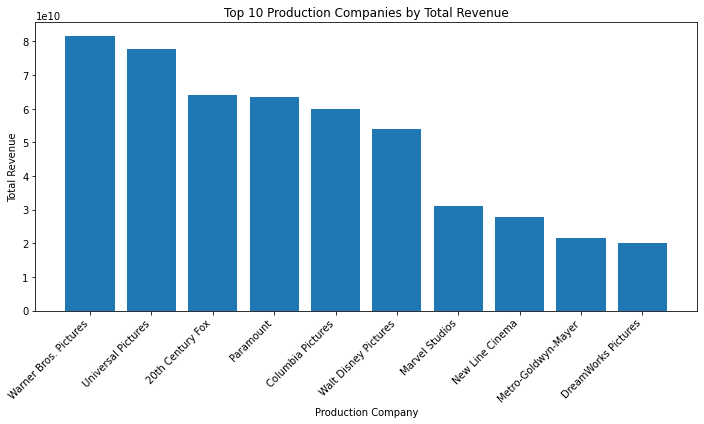

In [0]:
# Top 10 companies by total revenue & plot
prod_rev = (
    prod_exploded
      .groupBy("company")
      .agg(spark_sum("revenue").alias("total_revenue"))
      .orderBy(col("total_revenue").desc())
)
top10_prod = prod_rev.limit(10)
top10_prod.show(10, False)

# Plot
pd_top10_prod = top10_prod.toPandas()
plt.figure(figsize=(10,6))
plt.bar(pd_top10_prod["company"], pd_top10_prod["total_revenue"])
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Production Companies by Total Revenue")
plt.xlabel("Production Company")
plt.ylabel("Total Revenue")
plt.tight_layout()
plt.show()

In [0]:
# Create boolean flags for the top 6 most profitable companies
top6_prod = [row["company"] for row in prod_rev.limit(6).collect()]
for comp in top6_prod:
    flag_col = comp.lower().replace(" ", "_").replace(".", "").replace(",", "")
    df_copy3 = df_copy3.withColumn(
        flag_col,
        when(array_contains(col("prod_companies_array"), comp), 1).otherwise(0)
    )

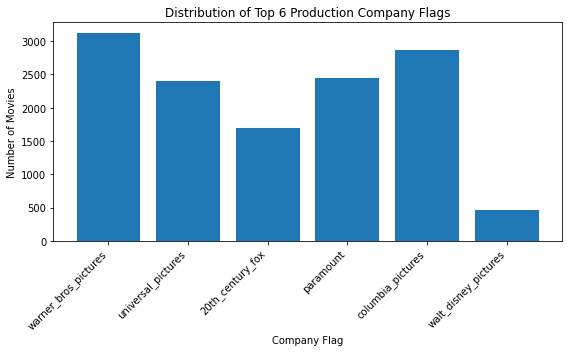

In [0]:
# Plot distribution of these boolean flags
bool_cols_prod = [c.lower().replace(" ", "_").replace(".", "").replace(",", "") for c in top6_prod]
dist_prod = (
    df_copy3
      .select([spark_sum(col(c)).alias(c) for c in bool_cols_prod])
      .toPandas()
      .melt(var_name="company", value_name="count")
)
plt.figure(figsize=(8,5))
plt.bar(dist_prod["company"], dist_prod["count"])
plt.xticks(rotation=45, ha="right")
plt.title("Distribution of Top 6 Production Company Flags")
plt.ylabel("Number of Movies")
plt.xlabel("Company Flag")
plt.tight_layout()
plt.show()

%md
For this variable to become useful for our model, it also needs to be converted into a binary system of 6 categories, representing the top 5 production companies by revenue, plus one additional category for all others.

%md
### PRODUCTION_COUNTRIES

In [0]:
# Summary for 'production_countries'
total = df_copy3.count()

nulls   = df_copy3.filter(col("production_countries").isNull()).count()
empties = df_copy3.filter((col("production_countries") == "") | (col("production_countries") == " ")).count()
nones   = df_copy3.filter(col("production_countries").isin("None", "none")).count()
zeros   = df_copy3.filter(col("production_countries") == "0").count()

print(f"production_countries: total={total}, nulls={nulls}, empty strings={empties}, 'None'/'none' strings={nones}, zero values={zeros}")

production_countries: total=1022770, nulls=453606, empty strings=0, 'None'/'none' strings=0, zero values=0


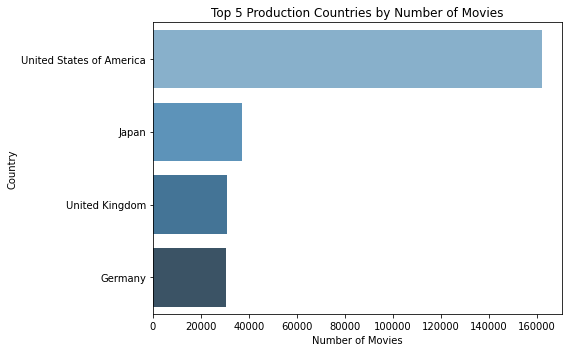

In [0]:
# Top 5 production_countries by number of movies

country_counts = (
    df_copy3
    .groupBy("production_countries")
    .count()
    .orderBy(col("count").desc())
    .limit(5)
    .toPandas()
)

plt.figure(figsize=(8,5))
sns.barplot(x="count", y="production_countries", data=country_counts, palette="Blues_d")
plt.title("Top 5 Production Countries by Number of Movies")
plt.xlabel("Number of Movies")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

%md
It is easy to observe that the United States is the largest producer of films. To make this variable useful for our model, we will also convert it into a binary system of five categories, representing the top film-producing countries

%md
### SPOKEN_LANGUAGES

In [0]:
# Summary for 'spoken_languages'
total = df_copy3.count()

nulls   = df_copy3.filter(col("spoken_languages").isNull()).count()
empties = df_copy3.filter((col("spoken_languages") == "") | (col("spoken_languages") == " ")).count()
nones   = df_copy3.filter(col("spoken_languages").isin("None", "none")).count()
zeros   = df_copy3.filter(col("spoken_languages") == "0").count()

print(f"spoken_languages: total={total}, nulls={nulls}, empty strings={empties}, 'None'/'none' strings={nones}, zero values={zeros}")

spoken_languages: total=1022770, nulls=433090, empty strings=0, 'None'/'none' strings=0, zero values=0


In [0]:
# Display distinct languages
display(
    df_copy3
      .select("spoken_languages")
      .distinct()
      .orderBy("spoken_languages")
      .limit(10)
)

spoken_languages
null
Abkhazian
"Abkhazian, English"
"Abkhazian, English, Georgian, Kurdish"
"Abkhazian, French, Georgian, English, Russian, Hungarian"
"Abkhazian, French, Russian"
"Abkhazian, Georgian, Russian, Turkish"
"Abkhazian, German"
"Abkhazian, Russian"
"Abkhazian, Spanish"


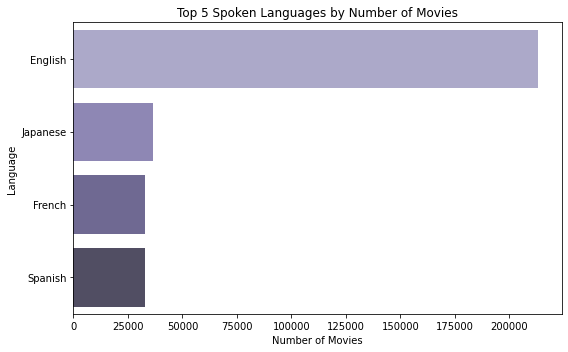

In [0]:
# Top 5 spoken_languages by number of movies
lang_counts = (
    df_copy3
    .groupBy("spoken_languages")
    .count()
    .orderBy(col("count").desc())
    .limit(5)
    .toPandas()
)

plt.figure(figsize=(8,5))
sns.barplot(x="count", y="spoken_languages", data=lang_counts, palette="Purples_d")
plt.title("Top 5 Spoken Languages by Number of Movies")
plt.xlabel("Number of Movies")
plt.ylabel("Language")
plt.tight_layout()
plt.show()

%md
For this variable as well, we will create a binary system with five elements, representing the four most frequent values along with one additional category for all remaining cases

%md
### KEYWORDS

In [0]:
# Summary for 'keywords'
total = df_copy3.count()

nulls   = df_copy3.filter(col("keywords").isNull()).count()
empties = df_copy3.filter((col("keywords") == "") | (col("keywords") == " ")).count()
nones   = df_copy3.filter(col("keywords").isin("None", "none")).count()
zeros   = df_copy3.filter(col("keywords") == "0").count()

print(f"keywords: total={total}, nulls={nulls}, empty strings={empties}, 'None'/'none' strings={nones}, zero values={zeros}")

keywords: total=1022770, nulls=736606, empty strings=0, 'None'/'none' strings=0, zero values=0


In [0]:
# Split & explode “keywords”
df_copy3 = df_copy3.withColumn(
    "keywords_array",
    split(
        regexp_replace(col("keywords"), r"\s*,\s*", ","), 
        ","
    )
)
kw_exploded = df_copy3.select(
    explode(col("keywords_array")).alias("keyword"),
    col("revenue")
)

In [0]:
# Count occurrences & distinct count
kw_counts = (
    kw_exploded
      .groupBy("keyword")
      .count()
      .orderBy(col("count").desc())
)
kw_counts.show(10, False)
print(f"Number of distinct keywords: {kw_counts.count()}")


+----------------------+-----+
|keyword               |count|
+----------------------+-----+
|short film            |24597|
|woman director        |15291|
|gay pornography       |9957 |
|based on novel or book|5714 |
|anal sex              |4863 |
|murder                |4658 |
|concert               |4602 |
|lgbt                  |4544 |
|biography             |3745 |
|silent film           |3588 |
+----------------------+-----+
only showing top 10 rows

Number of distinct keywords: 54603


+----------------------+-------------+
|keyword               |total_revenue|
+----------------------+-------------+
|sequel                |97895504832  |
|duringcreditsstinger  |96411643362  |
|based on novel or book|89882672735  |
|aftercreditsstinger   |73617092336  |
|based on comic        |70401286996  |
|superhero             |65566913992  |
|new york city         |46224761756  |
|california            |41075295752  |
|magic                 |37320370054  |
|friendship            |30300681066  |
+----------------------+-------------+



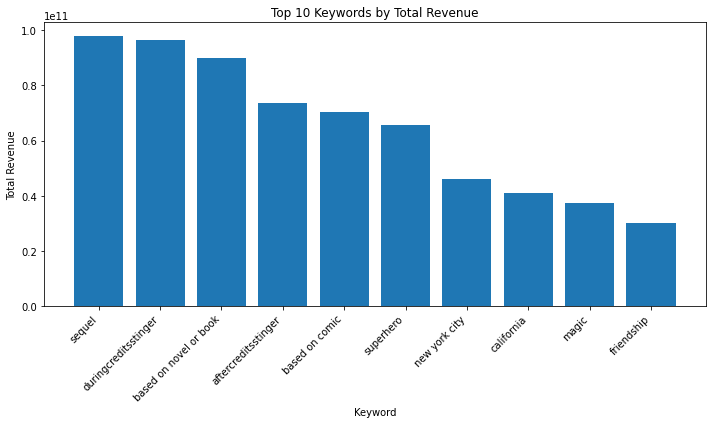

In [0]:
# Top 10 keywords by total revenue & plot
kw_rev = (
    kw_exploded
      .groupBy("keyword")
      .agg(spark_sum("revenue").alias("total_revenue"))
      .orderBy(col("total_revenue").desc())
)
top10_kw = kw_rev.limit(10)
top10_kw.show(10, False)

pd_top10_kw = top10_kw.toPandas()
plt.figure(figsize=(10,6))
plt.bar(pd_top10_kw["keyword"], pd_top10_kw["total_revenue"])
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Keywords by Total Revenue")
plt.xlabel("Keyword")
plt.ylabel("Total Revenue")
plt.tight_layout()
plt.show()

In [0]:
# Boolean flags for the top 3 most profitable keywords
top3_kw = [row["keyword"] for row in kw_rev.limit(3).collect()]
for kw in top3_kw:
    flag_col = kw.lower().replace(" ", "_").replace(".", "").replace(",", "")
    df_copy3 = df_copy3.withColumn(
        flag_col,
        when(array_contains(col("keywords_array"), kw), 1).otherwise(0)
    )

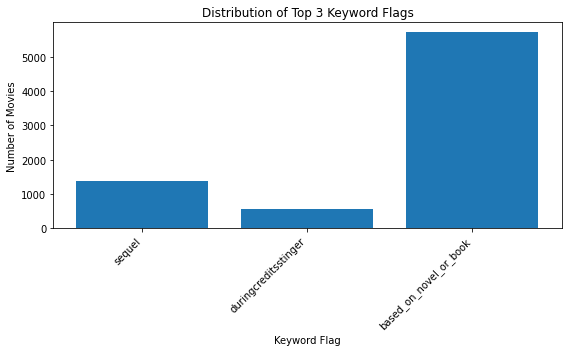

In [0]:
# Plot distribution of these boolean keyword flags
bool_cols_kw = [k.lower().replace(" ", "_").replace(".", "").replace(",", "") for k in top3_kw]
dist_kw = (
    df_copy3
      .select([spark_sum(col(c)).alias(c) for c in bool_cols_kw])
      .toPandas()
      .melt(var_name="keyword", value_name="count")
)
plt.figure(figsize=(8,5))
plt.bar(dist_kw["keyword"], dist_kw["count"])
plt.xticks(rotation=45, ha="right")
plt.title("Distribution of Top 3 Keyword Flags")
plt.ylabel("Number of Movies")
plt.xlabel("Keyword Flag")
plt.tight_layout()
plt.show()

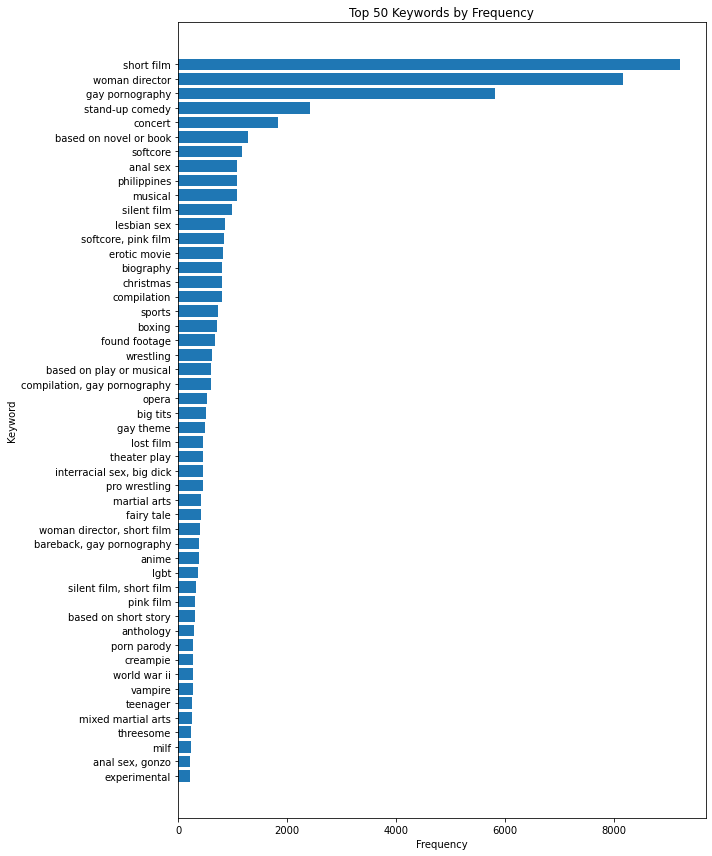

In [0]:
# Explode the 'keywords' string column into individual rows.
#    Adjust the delimiter in split() if your keywords are comma-separated, e.g. "," instead of "\\|"
keywords_exploded = df.select(
    explode(
        split(col("keywords"), "\\|")
    ).alias("keyword")
).filter(col("keyword") != "")

# 2) Count and take the top 50
top50 = (
    keywords_exploded
      .groupBy("keyword")
      .count()
      .orderBy(col("count").desc())
      .limit(50)
      .toPandas()
)

# 3) Plot as a horizontal bar chart with matplotlib
plt.figure(figsize=(10, 12))
plt.barh(top50["keyword"][::-1], top50["count"][::-1])
plt.xlabel("Frequency")
plt.ylabel("Keyword")
plt.title("Top 50 Keywords by Frequency")
plt.tight_layout()
plt.show()


+----------------------+---------+------------------+
|keyword               |frequency|avg_revenue       |
+----------------------+---------+------------------+
|short film            |9228     |189.30104031209362|
|woman director        |8170     |64327.386780905756|
|gay pornography       |5812     |0.0               |
|stand-up comedy       |2415     |25303.35817805383 |
|concert               |1844     |122303.52223427332|
|based on novel or book|1276     |149923.6896551724 |
|softcore              |1178     |7.907470288624788 |
|anal sex              |1084     |0.0               |
|philippines           |1078     |15144.059369202227|
|musical               |1075     |166695.72837209303|
+----------------------+---------+------------------+



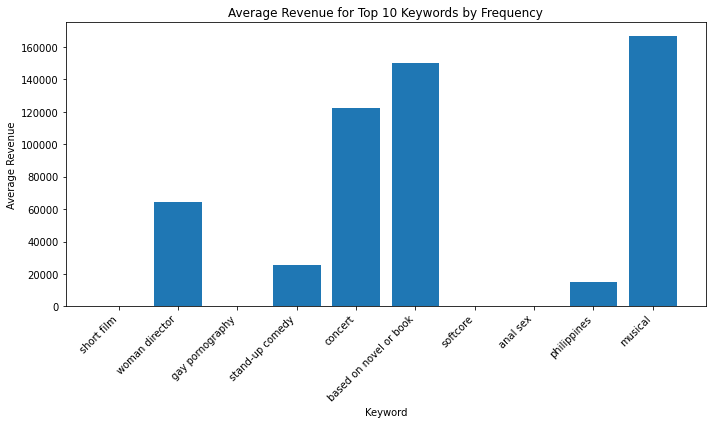

In [0]:
# 1) Explode keywords and carry revenue along
keywords_df = df.select(
    explode(split(col("keywords"), "\\|")).alias("keyword"),
    col("revenue").cast("double")
).filter(col("keyword") != "")

# 2) Compute frequency and average revenue per keyword
kw_stats = (
    keywords_df
      .groupBy("keyword")
      .agg(
          count("*").alias("frequency"),
          avg("revenue").alias("avg_revenue")
      )
)

# 3) Take top 10 keywords by frequency
top10 = (
    kw_stats
      .orderBy(col("frequency").desc())
      .limit(10)
)

# 4) Show the results in Spark
top10.show(truncate=False)

# 5) (Optional) Convert to Pandas and plot average revenue
pd_top10 = top10.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(pd_top10["keyword"], pd_top10["avg_revenue"])
plt.xlabel("Keyword")
plt.ylabel("Average Revenue")
plt.title("Average Revenue for Top 10 Keywords by Frequency")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


%md
## New Features

%md
### Profit and ROI

In [0]:
# Filter out rows with zero or null budget or revenue to avoid division errors
df_money = df.filter((col("budget") > 0) & (col("revenue") > 0))

# Create 'profit' and 'roi' columns
df_money = df_money.withColumn("profit", col("revenue") - col("budget"))
df_money = df_money.withColumn("roi", col("revenue") / col("budget"))

In [0]:
# Describe the statistics for 'profit' and 'roi' columns in PySpark
df_money.describe(['profit', 'roi']).show()

+-------+--------------------+--------------------+
|summary|              profit|                 roi|
+-------+--------------------+--------------------+
|  count|               14165|               14165|
|   mean|3.4643377595552415E7|  361102.07822910196|
| stddev|1.3546438856865352E8|1.5581518627174255E7|
|    min|          -899999984|4.444444444444444E-9|
|    max|          4999999899|               1.0E9|
+-------+--------------------+--------------------+



%md
#### Check only de ROI > 0

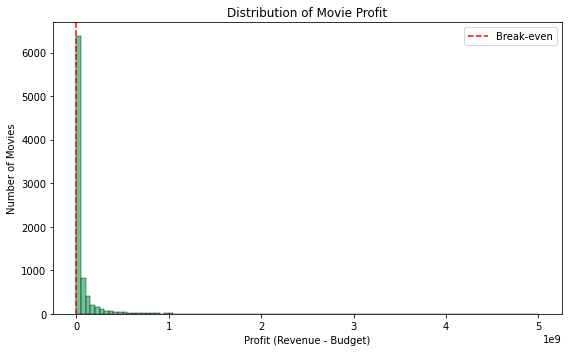

In [0]:
# Step 1: Calculate profit and ROI
df_money = df.withColumn("profit", col("revenue") - col("budget"))
df_money = df_money.withColumn("roi", col("revenue") / col("budget"))

# Step 2: Filter for positive profit and ROI
profit_roi_filtered = df_money.filter((col('profit') > 0) & (col('roi') > 0))

# Step 3: Convert to pandas DataFrame for plotting
profit_roi_filtered_pd = profit_roi_filtered.select('profit').toPandas()

# Step 4: Plot the distribution of profit
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(profit_roi_filtered_pd['profit'], bins=100, color='mediumseagreen')
plt.title('Distribution of Movie Profit')
plt.xlabel('Profit (Revenue - Budget)')
plt.ylabel('Number of Movies')
plt.axvline(0, color='red', linestyle='--', label='Break-even')
plt.legend()
plt.tight_layout()
plt.show()

%md
#### Movies with the highest profit

In [0]:
# Step 1: Sort by profit in descending order and get the top 10 movies
top_profit = profit_roi_filtered.orderBy(col('profit'), ascending=False).limit(10)

# Step 2: Select the relevant columns (title, revenue, budget, profit)
top_profit_selected = top_profit.select('title', 'revenue', 'budget', 'profit')

# Step 3: Convert to pandas DataFrame to display in a table
top_profit_selected_pd = top_profit_selected.toPandas()

# Step 4: Display the result
print(top_profit_selected_pd)

                          title     revenue     budget      profit
0             babben: the movie  4999999999        100  4999999899
1                     Bee Movie  2930000000  150000000  2780000000
2             TikTok Rizz Party  3000000000  250000000  2750000000
3                        Avatar  2923706026  237000000  2686706026
4             Avengers: Endgame  2800000000  356000000  2444000000
5       Adventures in Bora Bora  3000000000  800000000  2200000000
6                       Titanic  2264162353  200000000  2064162353
7                   Best Of Joy  2000000000       1000  1999999000
8      Avatar: The Way of Water  2320250281  460000000  1860250281
9  Star Wars: The Force Awakens  2068223624  245000000  1823223624


%md
#### Movies with the highest ROI

In [0]:
# Step 1: Sort by ROI in descending order and get the top 10 movies
top_roi = profit_roi_filtered.orderBy(col('roi'), ascending=False).limit(10)

# Step 2: Select the relevant columns (title, budget, revenue, roi)
top_roi_selected = top_roi.select('title', 'budget', 'revenue', 'roi')

# Step 3: Convert to pandas DataFrame to display in a table
top_roi_selected_pd = top_roi_selected.toPandas()

# Step 4: Display the result
print(top_roi_selected_pd)


                              title  budget     revenue           roi
0                ירידתם של המגניבים       1  1000000000  1.000000e+09
1  GEESE - THE MONEY TALKS TOUR '24       1  1000000000  1.000000e+09
2             Pouring Out The Heart       1  1000000000  1.000000e+09
3                     Lil Detective       2   999999999  5.000000e+08
4                   חברים על סמים 2       5  1000000000  2.000000e+08
5                              דילן       5  1000000000  2.000000e+08
6                   חברים על סמים 1       5  1000000000  2.000000e+08
7                Żyraf: Czas Zemsty       1   100004215  1.000042e+08
8                         The Light       1   100000000  1.000000e+08
9                            ¡Slap!       1   100000000  1.000000e+08


%md
## Correlation Matrix for Popularity, Vote_Count and Revenue

In [0]:
# Convert to pandas for correlation analysis
df_pd = df.select('popularity', 'vote_count', 'revenue').toPandas()

# Compute correlation matrix
correlation_popularity = df_pd.corr()

# Display the correlation matrix
print("Correlation between Popularity, Vote Count, and Revenue:")
print(correlation_popularity)

Correlation between Popularity, Vote Count, and Revenue:
            popularity  vote_count   revenue
popularity    1.000000    0.254086  0.217021
vote_count    0.254086    1.000000  0.667021
revenue       0.217021    0.667021  1.000000


%md
Vote count appears to have the strongest relationship with revenue.

Both popularity and vote count are positively correlated with revenue, but the relationship with popularity is weaker compared to the relationship between vote count and revenue.

In [0]:
# To check the type of each feature
df.printSchema()
# Function to calculate missing values by column
def missing_values_table_spark(df):
    """
    Calculates the total number and percentage of missing (null) values 
    for each column in a PySpark DataFrame.

    Returns a Pandas DataFrame with columns:
    - 'Column': column name
    - 'Missing Values': count of missing values
    - '% of Total Values': percentage of missing values
    
    Only columns with missing values are included, sorted in descending order.
    """
    # Calculate the total missing values for each column
    mis_val = df.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df.columns])

    # Convert to Pandas for easier handling
    mis_val_pd = mis_val.toPandas().transpose()

    # Calculate the percentage of missing values for each column
    mis_val_percent = (mis_val_pd[0] / df.count()) * 100

    # Create a new table combining count and percentage
    mis_val_table = pd.concat([mis_val_pd, mis_val_percent], axis=1)
    mis_val_table.columns = ['Missing Values', '% of Total Values']

    # Keep only columns with >0% missing, sort descending, round
    mis_val_table = (
        mis_val_table[mis_val_table['% of Total Values'] > 0]
        .sort_values('% of Total Values', ascending=False)
        .round(1)
    )

    # Reset index so that original column names become a column
    mis_val_table = mis_val_table.reset_index().rename(columns={'index': 'Column'})

    # Print summary
    print(f"Your selected dataframe has {len(df.columns)} columns.\n"
          f"There are {mis_val_table.shape[0]} columns that have missing values.")

    return mis_val_table

# Usage
missing_values = missing_values_table_spark(df)
display(missing_values)

root
 |-- id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- vote_average: double (nullable = true)
 |-- vote_count: integer (nullable = true)
 |-- status: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- revenue: long (nullable = true)
 |-- runtime: integer (nullable = true)
 |-- adult: boolean (nullable = true)
 |-- budget: integer (nullable = true)
 |-- imdb_id: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: double (nullable = true)
 |-- tagline: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- spoken_languages: string (nullable = true)
 |-- keywords: string (nullable = true)

Your selected dataframe has 21 columns.
There are 11 columns that have missing values.


Column,Missing Values,% of Total Values
tagline,895849,85.4
keywords,755953,72.1
production_companies,568428,54.2
imdb_id,487595,46.5
production_countries,463497,44.2
spoken_languages,440662,42.0
genres,414972,39.6
overview,215824,20.6
release_date,181817,17.3
title,13,0.0


%md
### Save the DataSet

In [0]:
df = df_copy3

In [0]:
# to save our dataset
df.write.mode("overwrite").parquet("/FileStore/tables/Imdb_Movie_Dataset-4.csv")
display(df.limit(5))

id,title,vote_average,vote_count,release_date,revenue,runtime,adult,budget,imdb_id,original_language,overview,popularity,tagline,genres,production_companies,production_countries,spoken_languages,keywords,en_bool,tagline_bool,genres_array,action,adventure,comedy,drama,thriller,prod_companies_array,warner_bros_pictures,universal_pictures,20th_century_fox,paramount,columbia_pictures,walt_disney_pictures,keywords_array,sequel,duringcreditsstinger,based_on_novel_or_book
257391,Mahal,5.5,8,1/1/1949,0,165,false,0,tt0041619,hi,"A young lawyer is involved with a ghostly woman in his new house, where the builder and his fiancée died shortly after it was built.",1.735,null,"Romance, Horror, Drama",Bombay Talkies,India,Hindi,"reincarnation, ghost story",0,0,"List(Romance, Horror, Drama)",0,0,0,1,0,List(Bombay Talkies),0,0,0,0,0,0,"List(reincarnation, ghost story)",0,0,0
593495,The Reliant,3.9,8,10/24/2019,0,140,false,0,tt6105774,en,"Economic collapse causes widespread rioting and social unrest, leaving a lovesick 19-year-old girl struggling to care for her siblings in a stretch of woods bordered by lawless anarchy, wondering why a good God would let this happen.",1.978,Why do bad things happen to good people?,"Action, Family",Fervent House Media,United States of America,English,"based on novel or book, riot, lawlessness, god, anarchy, social unrest",1,1,"List(Action, Family)",1,0,0,0,0,List(Fervent House Media),0,0,0,0,0,0,"List(based on novel or book, riot, lawlessness, god, anarchy, social unrest)",0,0,1
198526,The Magic Touch,6.9,8,1/24/1992,0,100,false,0,tt0105386,cn,"Hui Wai-kuk (Michael Hui) tells people's fortunes by feeling their bones. In reality though, he is a scam artist who gathers information on his clients in advance and uses it to milk them for money. When the wife of Commissioner David Ho (Philip Chan) of the Inland Revenue Department (IRD) comes to see him, he reveals that her husband is cheating on her. After facing the wrath of his wife, Ho decides to get revenge and sends junior assessor Yau Ho-kei (Leon Lai) to investigate Hui's income. During the investigation, Hui sustains a brain injury and slips into a coma. After he wakes up, he suddenly discovers that he has gained the real ability to see people's futures.",1.742,null,Comedy,"Hui's Film Production Co., Ltd., Topping Time Films Ltd.",Hong Kong,Cantonese,null,0,0,List(Comedy),0,0,1,0,0,"List(Hui's Film Production Co., Ltd., Topping Time Films Ltd.)",0,0,0,0,0,0,null,0,0,0
102508,Platillos volantes,5.5,8,11/7/2003,0,99,false,0,tt0388341,es,"Based on real events, in 1972 Juan and José are two textile workers from Tarrasa, Catalonia (northeast to Spain) who meet during an UFOs' convention. Both share their passion about the paranormal, specially about UFOs. In these years where was very much UFOs' sightings, they feel captivated by the mystery and start to investigate the diverse theories about the intentions or purposes of the sightings. Their friendship and the obsession they have will turn in dementia and paranoia, hurting their relations with their respective friends and familiars and exposing their lives to an extreme decision due to the conclusion of their own investigations. Written by Chockys",2.031,null,"Drama, Science Fiction",Enrique Cerezo,Spain,Spanish,null,0,0,"List(Drama, Science Fiction)",0,0,0,1,0,List(Enrique Cerezo),0,0,0,0,0,0,null,0,0,0
247477,Law and Disorder,6.2,8,6/9/1958,0,76,false,0,tt0051847,en,"When Percy Brand, a habitual confidence trickster, keeps being sent down, he goes to great lengths to ensure that his son Colin, does not find out about his criminal past. But when Colin becomes an assistant to the Judge, who is about to try Percy for his latest escapade, Percy and his gang have to come up with a plan, to stop them meeting in court.",1.937,Michael Redgrave with an ingenious hand for disorder ... Robert Morley as the intrepid arm of the law ...,Comedy,"Paul Soskin Productions, British Lion Films",United Kingdom,English,lawyer,1,1,Li